# MECANISMO BIELA-MANIVELA INVERTIDA

## PROBLEMAS VELOCIDAD Y ACELERACIÓN

### PASO 1: MATRIZ JACOBIANA 

Para resolver el problema velocidad, necesitamos otra vez la matriz jacobiana. El método de construcción aparece detallado en el notebook Problema_Posición_BMI, por lo que para este caso copiaremos el código de los pasos realizados para poder conseguirla.

In [1]:
import numpy as np
import math as math
import array as arr
import pprint  # para depurar
import matplotlib.pyplot as plt  #Para graficas
import matplotlib.animation as animation
import scipy.integrate as integrate 
import os
from time import sleep
#%matplotlib inline (Para notebook)



print ('BIELA-MANIVELA INVERTIDA')
print ('=============================')
# Lectura de datos por teclado

meca = {} # dictionary vacio, con propiedades de mecanismo

meca["L1"] = float (input ('Introduce longitud L1:'))
meca["L2"] = float (input ('Introduce longitud L2:'))
meca["L3"] = float (input ('Introduce longitud L3: '))
meca["theta"] = float (input ('Introduce angulo inicial theta:')) #En rad
meca["beta"] = float (input ('Introduce angulo inicial beta: '))
meca["XB"] = float (input ('Introduce coordenada en x del punto B:'))
meca["YB"] = 0 #float (input ('Introduce coordenada en y del punto B:'))
meca["XA"] = 0
meca["YA"] = 0

# Defino posicion inicial:
q = np.array ([[0.1], [0.2], [1], [0.2], [meca["XB"]+meca["L3"]*math.cos(meca["beta"])], [meca["YB"]+meca["L3"]*math.sin(meca["beta"])], [meca["theta"]], [meca["beta"]]])
print('q: ' + str(q))

# JACOBIANO
def jacob_Phiq(q,meca):
    #Inicializa a cero la matriz jacobiana
    Jacob = np.zeros((8,8))

    #Extraer coordenadas

    X1 = q[0]
    Y1 = q[1]
    X2 = q[2]
    Y2 = q[3]
    X3 = q[4]
    Y3 = q[5]
    theta = q[6]
    beta = q[7]

    #Montar matriz

    Jacob[0,0] = 2*X1
    Jacob[0,1] = 2*Y1
    Jacob[1,0] = -2*(X2-X1)
    Jacob[1,1] = -2*(Y2-Y1)
    Jacob[1,2] = 2*(X2-X1)
    Jacob[1,3] = 2*(Y2-Y1)
    Jacob[2,4] = -2*(meca["XB"]-X3)
    Jacob[2,5] = -2*(meca["YB"]-Y3)
    Jacob[3,0] = -(Y2-Y1) + (Y3-Y1)
    Jacob[3,1] = (X2-X1) - (X3-X1)
    Jacob[3,2] = -(Y3-Y1)
    Jacob[3,3] = X3-X1
    Jacob[3,4] = (Y2-Y1)
    Jacob[3,5] = -(X2-X1)

    if (abs(math.cos(theta)) < 0.95 ):
        Jacob[4,6] = meca["L1"]*math.sin(theta)
        Jacob[4,0] = 1
    else:
        Jacob[4,6] = -meca["L1"]*math.cos(theta)
        Jacob[4,1] = 1


    if (abs(math.cos(beta)) < 0.95 ):
        Jacob[5,7] = meca["L3"]*math.sin(beta)
        Jacob[5,4] = 1
    else:
        Jacob[5,7] = -meca["L3"]*math.cos(beta)
        Jacob[5,5] = 1


    Jacob[6,6] = 1
    Jacob[7,7] = 1

    return Jacob


def Phi (q,meca):
    #Inicializa a cero Phi
    Phi = np.zeros((8,1))

    #Extraer coordenadas
    X1 = q[0]
    Y1 = q[1]
    X2 = q[2]
    Y2 = q[3]
    X3 = q[4]
    Y3 = q[5]
    theta = q[6]
    beta = q[7]

    Phi[0] = X1**2 + Y1**2 - meca["L1"]**2
    Phi[1] = (X2-X1)**2 + (Y2-Y1)**2 - meca["L2"]**2
    Phi[2] = (meca["XB"]-X3)**2 + (meca["YB"]-Y3)**2 - meca["L3"]**2
    Phi[3] = (X3-X1)*(Y2-Y1) - (X2-X1)*(Y3-Y1)
     
    if (abs(math.cos(theta)) < 0.95):
        Phi[4] = X1-meca["L1"]*math.cos(theta)
    else: 
        Phi[4] = Y1-meca["L1"]*math.sin(theta)


    if (abs(math.cos(beta)) < 0.95):
        Phi[5] = (X3-meca["XB"])-meca["L3"]*math.cos(beta)
    else: 
        Phi[5] = (Y3-meca["YB"])-meca["L3"]*math.sin(beta)


    return Phi



def resuelve_prob_posicion(q_init, meca):
    #Inicializacion de variables
    error = 1e10
    tolerancia = 1e-10

    #Inicializacion en cero de deltaQ, fi y q
    deltaQ = np.zeros ((8,1))
    q = q_init
    i=0

    # Iteraciones hasta conseguir que el error sea menor que la tolerancia

    while (error > tolerancia and i<=100):
        #print("q=")
        #pprint.pprint(q)


        #Extraer las coordenadas
        X1 = q[0]
        Y1 = q[1]
        X2 = q[2]
        Y2 = q[3]
        X3 = q[4]
        Y3 = q[5]
        theta = q[6]
        beta = q[7]
       
        fi=Phi(q,meca)

        J = jacob_Phiq(q,meca)
    
        rango = np.linalg.matrix_rank(J, 1e-5)
        
        deltaQ = np.linalg.solve(J,-fi)
        q = q + deltaQ
        error = np.linalg.norm(deltaQ)  # El error es el modulo del vector
        i=i+1
        
    if (error > tolerancia):
        raise Exception ('No se puede alcanzar la posición')

    return q

q = resuelve_prob_posicion(q,meca)

BIELA-MANIVELA INVERTIDA
Introduce longitud L1:2
Introduce longitud L2:3
Introduce longitud L3: 1
Introduce angulo inicial theta:0.5
Introduce angulo inicial beta: 0.8
Introduce coordenada en x del punto B:2
q: [[0.1       ]
 [0.2       ]
 [1.        ]
 [0.2       ]
 [2.69670671]
 [0.71735609]
 [0.5       ]
 [0.8       ]]


### PASO 2: PROBLEMA VELOCIDAD

Consiste en determinar las velocidades de todas las variables del mecanismo una vez sabemos su posición $q$ y la velocidad de los grados de libertad. 

Partimos de la ecuación:

$\Phi_q  =0 $

Derivando se obtiene:

$\Phi_q \dot{q} + \Phi_t = 0$

Siendo $\dot{q}$ el vector velocidad, $\Phi_q$ el jacobiano y $\Phi_t$ la derivada parcial de las ecuaciones de restricción respecto al tiempo. Para las ecuaciones de sólido rígido el valor de esta derivada es $0$. Solo tendría un valor no nulo la correspondiente al ángulo, que en ese caso tendría la velocidad que nosotros le indiquemos. 

De este modo la expresión quedaría:

$\Phi_q \dot{q} = -\Phi_t$

Este sistema de ecuaciones tiene infinitas soluciones y por tanto hay que ampliar añadiendo un dato conocido de velocidad, lo que se hace añadiendo una fila a la matriz de coeficientes del lado izquierdo y un dato a la columna del lado derecho de la ecuación por cada grado de libertad.

De esta forma llegamos a un sistema de ecuaciones lineal matricial de la forma:

$\mathbf{A} \mathbf{x} = \mathbf{b}$

Habría que multiplicar en ambas partes de la igualdad por la $A$ invertida en el lado izquierdo, del mismo modo que se hizo en el problema de posición. De esta manera quedaría:



$x = A^{-1} b$

In [2]:
#PASO 2

# Nota: es necesario que a la entrada, qp sea todo ceros
# menos los valores de velocidad en los g.d.l.

def resuelve_prob_velocidad(q,qp,meca):
    qp = np.linalg.solve(jacob_Phiq(q,meca),qp)
    #print ("qp=")
    #pprint.pprint(qp)
 
    return qp

qp = np.zeros ((8,1))
#Velocidad del gdl. En una vuelta completa del angulo se cumple angulo=2*Pi*t
qp[6]=1
qp[7]=2
qp = resuelve_prob_velocidad (q,qp, meca)
qp




array([[-0.95885108],
       [ 1.75516512],
       [-1.31819903],
       [ 0.35413793],
       [-1.43471218],
       [ 1.39341342],
       [ 1.        ],
       [ 2.        ]])

### PASO 3: PROBLEMA ACELERACIÓN

El problema aceleración trata de determinar las aceleraciones de todas las variables del mecanismo, conociendo la posición$q$, la velocidad $\dot{q}$ y las aceleraciones de los grados de libertad. 

Partimos la ecuación que se obtiene tras derivar la ecuación inicial para el problema de velocidad, es decir:

$\Phi_q \dot{q} + \Phi_t = 0$

Se deriva por segunda vez:

$\dot{\Phi}_q \dot{q} + \Phi_q \ddot{q} + \dot{\Phi}_t = 0$

Despejamos $\Phi_q \ddot{q}$:

$\Phi_q \ddot{q} = -\dot{\Phi}_t - \dot{\Phi}_q  \dot{q}$


Siendo $\Phi_q$ el jacobiano, $\ddot{q}$ el vector aceleración, $\dot{q}$ el vector velocidad, $\dot{\Phi}_q$ la derivada del jacobiano respecto al tiempo y $\dot{\Phi}_t$ es la derivada de las ecuaciones de restricción con respecto al tiempo, cuyo valor es nulo. Es decir, tendríamos:

$\Phi_q \ddot{q} = - \dot{\Phi}_q  \dot{q}$

Del mismo modo que en el problema velocidad, llamando $b$ al conjunto formado por $\dot{\Phi}_q  \dot{q}$  llegamos a un sistema de ecuaciones lineal matricial:

$ \mathbf{A} \mathbf{x} = \mathbf{b}$

Y despejando la $x$:

$\mathbf{x} = \mathbf{A}^{-1} \mathbf{b}$


El vector velocidad será:

\begin{equation}
\mathbf{q_p} = 
\begin{bmatrix}
\dot{X}_1 \\
\dot{Y}_1 \\
\dot{X}_2 \\
\dot{Y}_2 \\
\dot{X}_3 \\
\dot{Y}_3 \\
\dot{\theta}\\
\dot{\beta} \\
\end{bmatrix}
\end{equation}

Por otro lado, para calcular la derivada del jacobiano solo tenemos en cuenta las filas que hacen referencia a las ecuaciones de las coordenadas independientes, ya que la última que añadimos para poder realizar los cálculos era adicional. Teniendo en cuenta esto, la derivada del jacobiano sería:

\begin{equation}
\mathbf{\dot{\Phi}_q} = 
\begin{bmatrix}
2 \dot{X}_1 & 2 \dot{Y}_1 & 0 & 0 & 0 & 0 & 0 & 0  \\
-2( \dot{X}_2 - \dot{X}_1) & -2( \dot{Y}_2 - \dot{Y}_1) & 2( \dot{X}_2 - \dot{X}_1) & 2( \dot{Y}_2 - \dot{Y}_1) & 0 & 0 & 0 & 0\\
0 & 0 & 0 & 0 & 2\dot{X}_3 & 2\dot{Y}_3 & 0 & 0   \\
-( \dot{Y}_2 - \dot{Y}_1) + ( \dot{Y}_3 - \dot{Y}_1) & (\dot{X}_2 - \dot{X}_1) - (\dot{X}_3 - \dot{X}_1) & -\dot{Y}_3 - \dot{Y}_1& \dot{X}_3 - \dot{X}_1 & \dot{Y}_2 - \dot{Y}_1 & -(\dot{X}_2 - \dot{X}_1) & 0 & 0\\
\dot{\theta}_q(4) \\
\dot{\theta}_q(5)\\
\end{bmatrix}
\end{equation}

Siendo:

1. $Si ~~ \cos (\theta) < {0.95} \rightarrow \dot{\Phi}_q(4) = \dot{\theta} · L_1 · \cos(\theta)$

2. $Si ~~ \cos (\theta) > {0.95} \rightarrow \dot{\Phi}_q(4) =  \dot{\theta} · L_1 · \sin(\theta)$

3. $Si ~~ \cos (\beta) < {0.95} \rightarrow \dot{\Phi}_q(5) = \dot{\beta} · L_3 · \cos(\beta)$

4. $Si ~~ \cos (\beta) > {0.95} \rightarrow \dot{\Phi}_q(5) = \dot{\beta} · L_3 · \sin(\beta)$


Como ya tenemos $\dot{\Phi}_q$ y $\dot{q}$, podemos calcular $b$. Las dos  últimas filas que añadimos son los valores de las aceleraciones angulares, datos que sabemos de antemano. 

\begin{equation}
\mathbf{b} = 
\begin{bmatrix}
2\dot{X}_1^2 & 2\dot{Y}_1^2 & 0 & 0 & 0 & 0 & 0 & 0  \\
-2\dot{X}_1 (\dot{X}_2-\dot{X}_1) & -2\dot{Y}_1 (\dot{Y}_2-\dot{Y}_1) & 2\dot{X}_2(\dot{X}_2-\dot{X}_1) & 2\dot{Y}_2(\dot{Y}_2-\dot{Y}_1) & 0 & 0 & 0 & 0\\
0 & 0 & 0 & 0 & 2\dot{X}_3^2 & 2\dot{Y}_3^2 & 0 & 0   \\
-\dot{X}_1((\dot{Y}_2-\dot{Y}_1)+(\dot{Y}_3-\dot{Y}_1)) & \dot{Y}_1((\dot{X}_2-\dot{X}_1)-(\dot{X}_3-\dot{X}_1)) & \dot{X}_2(-\dot{Y}_3-\dot{Y}_1) & \dot{Y}_2(\dot{X}_3-\dot{X}_1) & \dot{X}_3(\dot{Y}_2-\dot{Y}_1) & \dot{Y}_3(-(\dot{X}_2-\dot{X}_1)) & 0 & 0\\
b(4) \\
b(5)\\
1\\
1\\
\end{bmatrix}
\end{equation}

1. $Si ~~ \cos (\theta) < {0.95} \rightarrow b(4) = \dot{\theta}^2 · L_1 · \cos(\theta)$

2. $Si ~~ \cos (\theta) > {0.95} \rightarrow b(4) =  \dot{\theta}^2 · L_1 · \sin(\theta)$

3. $Si ~~ \cos (\beta) < {0.95} \rightarrow b(5) = \dot{\beta}^2 · L_3 · \cos(\beta)$

4. $Si ~~ \cos (\beta) > {0.95} \rightarrow b(5) = \dot{\beta}^2 · L_3 · \sin(\beta)$


In [3]:
#PASO 3

# Nota: es necesario que a la entrada, qpp sea todo ceros
# menos los valores de aceleración deseados en los g.d.l.

def resuelve_prob_aceleracion (q,qp,qpp,meca):

    #Extraer las posiciones
    X1 = q[0]
    Y1 = q[1]
    X2 = q[2]
    Y2 = q[3]
    X3 = q[4]
    Y3 = q[5]
    theta = q[6]
    beta = q[7]
    #Extraer las velocidades
    X1q = qp[0]
    Y1q = qp[1]
    X2q = qp[2]
    Y2q = qp[3]
    X3q = qp[4]
    Y3q = qp[5]
    thetaq = qp[6]
    betaq = qp[7]
    b=qpp
    
    b[0] = 2*(X1q)**2 + 2*(Y1q)**2
    b[1] = -2*X1q*(X2q-X1q) - 2*Y1q*(Y2q-Y1q) + 2*X2q*(X2q*X1q) + 2*Y2q*(Y2q*Y1q)
    b[2] = 2*X3q**2 + 2*Y3q**2 
    b[3] = -2*X1q*((Y2q-Y1q)+(Y3q-Y1q)) + Y1q*((X2q-X1q)-(X3q-X1q)) + X2q*(-Y3q-Y1q) + Y2q*(X3q-X1q) + X3q*(Y2q-Y1q) -Y3q*(X2q-X1q)
    
    if (abs(math.cos(theta)) < 0.95 ):
        b[4] = thetaq**2 * (meca["L1"] * math.cos(theta))
    else: 
        b[4] = thetaq**2 * (meca["L1"] * math.sin(theta))
    
    if (abs(math.cos(beta)) < 0.95 ):
        b[5] = betaq**2 * (meca["L3"] * math.cos(beta))
    else: 
        b[5] = betaq**2 * (meca["L3"] * math.sin(beta))

    qpp = np.linalg.solve(-jacob_Phiq(q,meca),b)

     
    return qpp


qpp=np.zeros ((8,1))
qpp[6] = 1 #Aceleracion conocida 
qpp[7] = 1
qpp = resuelve_prob_aceleracion (q,qp,qpp,meca)
qpp

array([[-0.79631405],
       [-2.7140162 ],
       [-2.73535687],
       [-9.3771278 ],
       [-2.06947075],
       [-3.56613107],
       [-1.        ],
       [-1.        ]])

### PASO 4: GRÁFICAS DE VELOCIDADES

Vamos a representar por separado la gráfica de la velocidad en cada coordenada $(X_1, ~ Y_1, ~ X_2, ~ Y_2, ~ X_3 ~ e ~ Y_3)$.

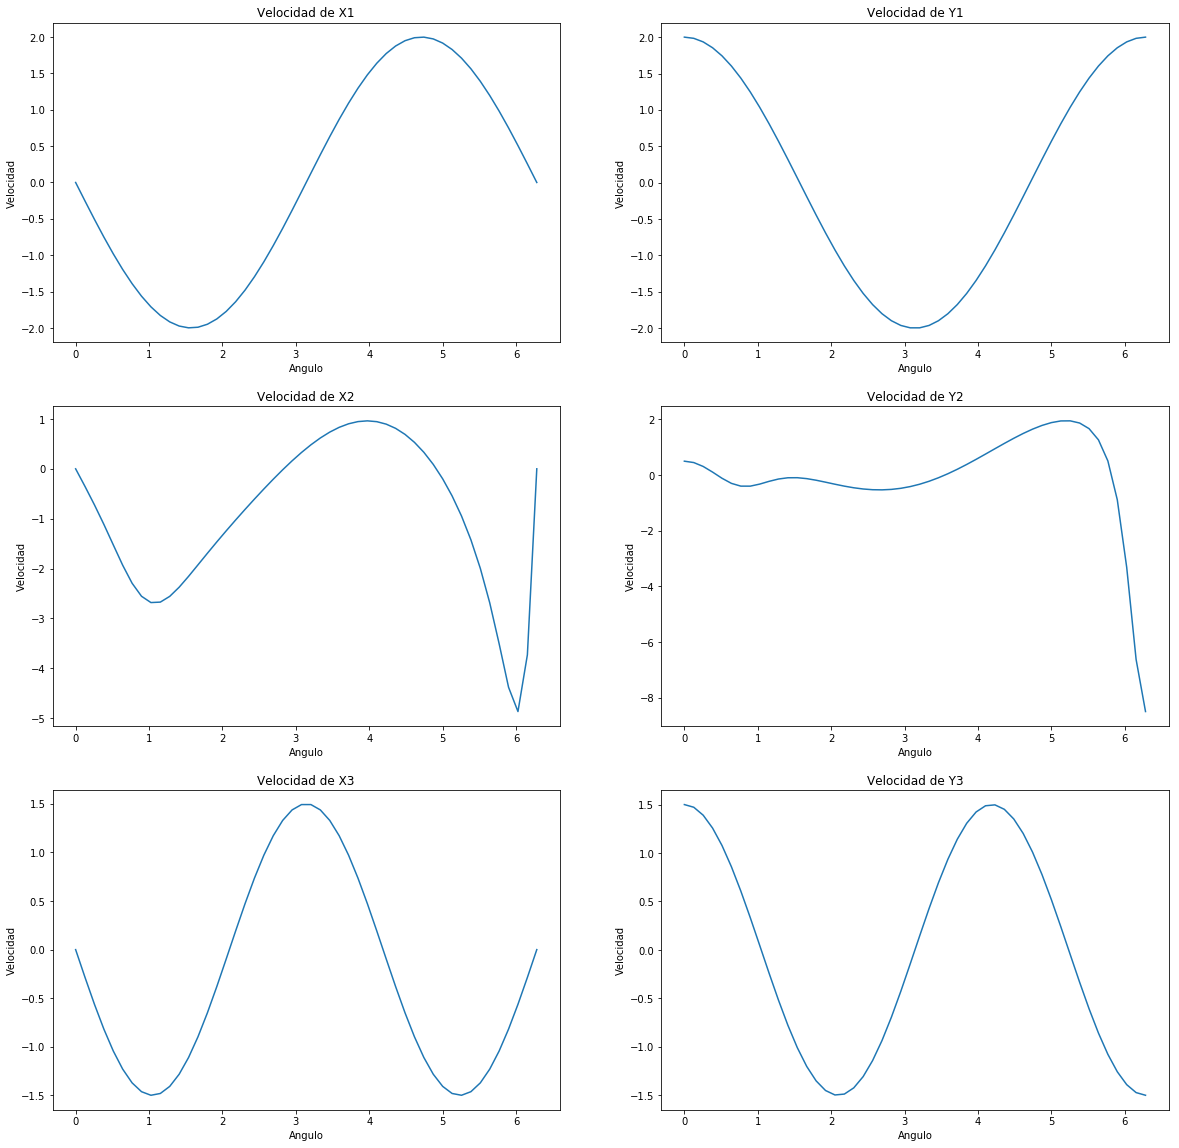

In [4]:
#PASO 4: GRÁFICAS DE VELOCIDADES
def grafica_velocidad(q,meca):
    
    th = np.linspace(0,2*3.1416,50)

    VX1 = np.zeros((50,0))
    VY1 = np.zeros((50,0))
    VX2 = np.zeros((50,0))
    VY2 = np.zeros((50,0))
    VX3 = np.zeros((50,0))
    VY3 = np.zeros((50,0))
    
    i=0
    for t in th:

        omega1=1
        omega2=1.5
        q[6] = t*omega1
        q[7] = t*omega2
        
        q = resuelve_prob_posicion (q, meca)
        qp = np.zeros ((8,1))
        #Velocidad del gdl. En una vuelta completa del angulo se cumple angulo=2*Pi*t
        qp[6]=omega1
        qp[7]=omega2
        qp = resuelve_prob_velocidad (q,qp, meca)


        VX1 = np.append(VX1, qp[0])
        VY1 = np.append(VY1, qp[1])
        VX2 = np.append(VX2, qp[2])
        VY2 = np.append(VY2, qp[3])
        VX3 = np.append(VX3, qp[4])
        VY3 = np.append(VY3, qp[5])
        i=i+1
      

    fig, axs = plt.subplots(ncols=2, figsize=(20, 20))
    plt.subplot(3,2,1)
    plt.plot(th,VX1)
    plt.xlabel ('Angulo')
    plt.ylabel ('Velocidad')
    plt.title ('Velocidad de X1')

    plt.subplot(3,2,2)
    plt.plot(th,VY1)
    plt.xlabel ('Angulo')
    plt.ylabel ('Velocidad')
    plt.title ('Velocidad de Y1')
    
    plt.subplot(3,2,3)
    plt.plot(th,VX2)
    plt.xlabel ('Angulo')
    plt.ylabel ('Velocidad')
    plt.title ('Velocidad de X2')

    plt.subplot(3,2,4)
    plt.plot(th,VY2)
    plt.xlabel ('Angulo')
    plt.ylabel ('Velocidad')
    plt.title ('Velocidad de Y2')
    
    plt.subplot(3,2,5)
    plt.plot(th,VX3)
    plt.xlabel ('Angulo')
    plt.ylabel ('Velocidad')
    plt.title ('Velocidad de X3')

    plt.subplot(3,2,6)
    plt.plot(th,VY3)
    plt.xlabel ('Angulo')
    plt.ylabel ('Velocidad')
    plt.title ('Velocidad de Y3')

    plt.show()
    return 

grafica_velocidad (q,meca)

### PASO 5: GRÁFICAS ACELERACIONES

Haremos el mismo procedimiento que para la velocidad, representando en celdas separadas la aceleración de cada coordenada.

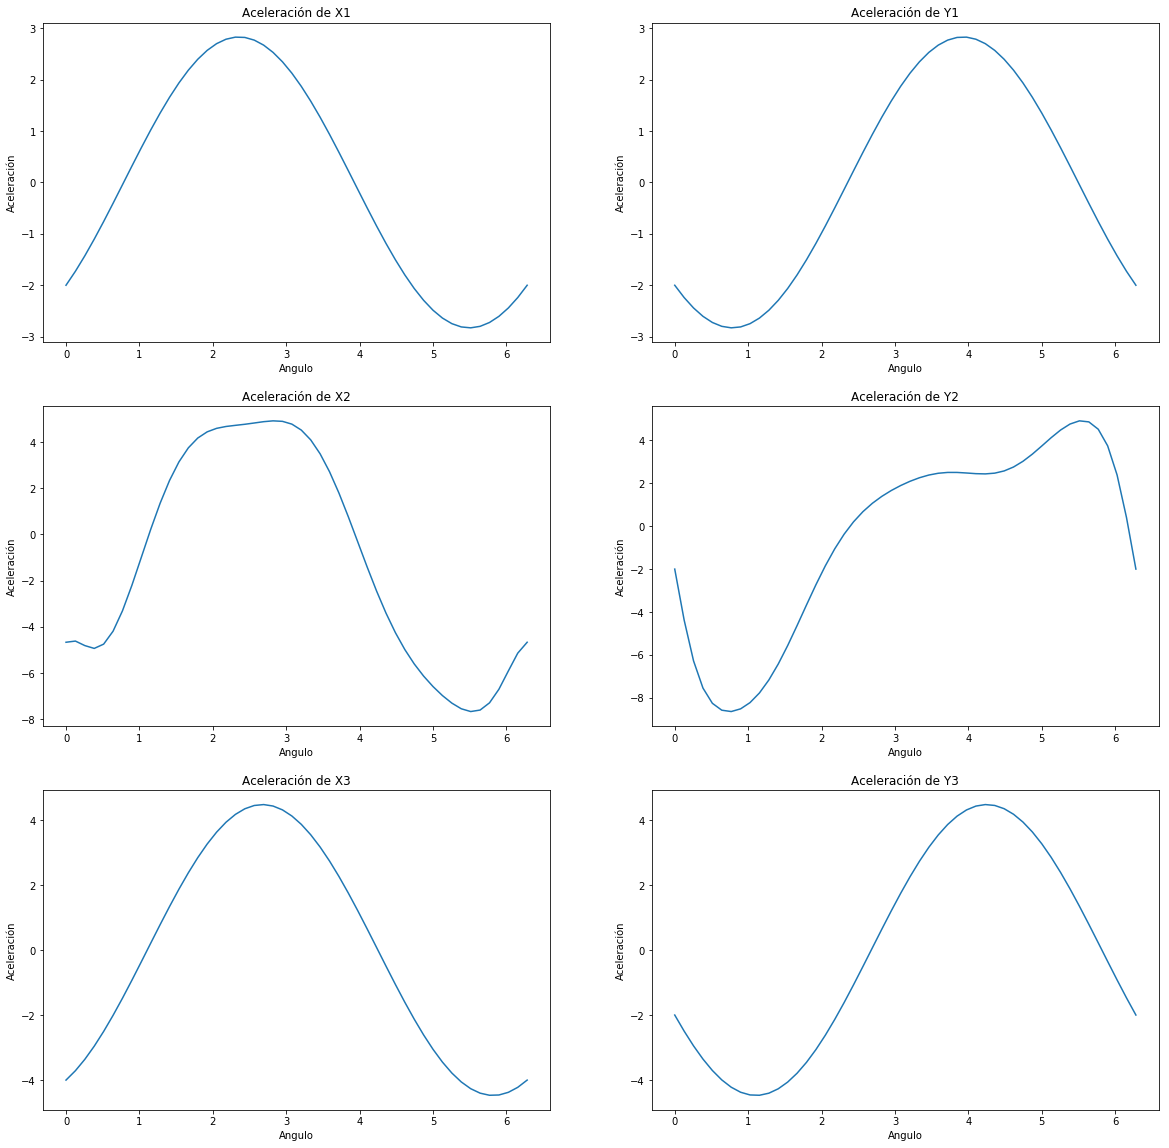

In [5]:
#PASO 5: GRÁFICAS ACELERACIONES

def grafica_aceleracion(q,meca):
    
    th = np.linspace(0,2*3.1416,50)

    AX1 = np.zeros((50,0))
    AY1 = np.zeros((50,0))
    AX2 = np.zeros((50,0))
    AY2 = np.zeros((50,0))
    AX3 = np.zeros((50,0))
    AY3 = np.zeros((50,0))

    
    i=0
    for t in th:

        q[6] = t
        q[7] = t
        q = resuelve_prob_posicion (q,meca)
        
        qp = np.zeros((8,1))
        qp[6] = 1  #inicializar qp en 0 con qp[6] = 1 rad/s
        qp[7] = 2
        qp = resuelve_prob_velocidad(q, qp, meca)
        
        qpp = np.zeros((8,1))
        qpp[6] = 1  #inicializar qp en 0 con qpp[4] = 1 rad/s**2
        qpp[7] = 2
        qpp = resuelve_prob_aceleracion(q,qp, qpp, meca)
        
        AX1 = np.append(AX1, qpp[0])
        AY1 = np.append(AY1, qpp[1])
        AX2 = np.append(AX2, qpp[2])
        AY2 = np.append(AY2, qpp[3])
        AX3 = np.append(AX3, qpp[4])
        AY3 = np.append(AY3, qpp[5])
        i=i+1

 
    fig, axs = plt.subplots(ncols=2, figsize=(20, 20))
    plt.subplot(3,2,1)
    plt.plot(th,AX1)
    plt.xlabel ('Angulo')
    plt.ylabel ('Aceleración')
    plt.title ('Aceleración de X1')

    plt.subplot(3,2,2)
    plt.plot(th,AY1)
    plt.xlabel ('Angulo')
    plt.ylabel ('Aceleración')
    plt.title ('Aceleración de Y1')
    
    plt.subplot(3,2,3)
    plt.plot(th,AX2)
    plt.xlabel ('Angulo')
    plt.ylabel ('Aceleración')
    plt.title ('Aceleración de X2')

    plt.subplot(3,2,4)
    plt.plot(th,AY2)
    plt.xlabel ('Angulo')
    plt.ylabel ('Aceleración')
    plt.title ('Aceleración de Y2')
    
    plt.subplot(3,2,5)
    plt.plot(th,AX3)
    plt.xlabel ('Angulo')
    plt.ylabel ('Aceleración')
    plt.title ('Aceleración de X3')

    plt.subplot(3,2,6)
    plt.plot(th,AY3)
    plt.xlabel ('Angulo')
    plt.ylabel ('Aceleración')
    plt.title ('Aceleración de Y3')

    plt.show()
    return 

grafica_aceleracion (q,meca)
